# 5. Monitor a Model Endpoint using SageMaker Model Monitor

* Goals
    * Create a baselining job to learn training dataset contraints and statistics
    * Enable data capture to store input feature data
    * Compare input data to constraints and statistics from the training set
    * Visualize differences in the distributions

---
## 1. Setup

Change into the notebooks directory.

In [5]:
%cd /root/sagemaker-workshop-420/notebooks

/root/sagemaker-workshop-420/notebooks


In [6]:
import boto3
import numpy as np
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.model import Model

In [7]:
boto_session = boto3.Session()
region = boto_session.region_name
sagemaker_session = sagemaker.Session()
role = get_execution_role()
print(role)

arn:aws:iam::209970524256:role/service-role/AmazonSageMaker-ExecutionRole-20200414T065516


In [8]:
BUCKET = 'sagemaker-workshop-420'
PREFIX = 'xgb-churn'

LOCAL_DATA_DIRECTORY = f'../data/{PREFIX}'

print(f"\nArtifacts will be written to/read from s3://{BUCKET}/{PREFIX}")


Artifacts will be written to/read from s3://sagemaker-workshop-420/xgb-churn


---
## 2. Load the pretrained XGBoost model

The serialized model path can be located in the Training Jobs section of the AWS SageMaker Console.

In [9]:
model_s3_path = 's3://sagemaker-workshop-420/xgb-churn/xgboost-churn-builtin-2020-04-15-22-50-24-089/output/model.tar.gz'
xgboost_image_name = get_image_uri(boto_session.region_name, 'xgboost', repo_version='0.90-2')

In [10]:
xgboost_model = Model(model_data=model_s3_path,
                      image=xgboost_image_name,
                      role=role,
                      sagemaker_session=sagemaker_session)

---
## 3.Enabling Data Capture

To monitor a model after it's hosted and serving requests, we need to configure SageMaker to capture data that is being sent to the endpoint. 

### Step 1. Create a `DataCaptureConfig` object

To configure Data Capture, we create a `sagemaker.model_monitor.DataCaptureConfig` object that specifies how much data to capture and where to store it.

In [11]:
import time
from time import strftime, gmtime
from sagemaker.model_monitor import DataCaptureConfig, DatasetFormat, DefaultModelMonitor
from sagemaker.predictor import csv_serializer, RealTimePredictor

In [12]:
captured_data_s3_uri = f's3://{BUCKET}/{PREFIX}/model-monitor/data-capture'

data_capture_config = DataCaptureConfig(enable_capture=True,
                                        sampling_percentage=100,
                                        destination_s3_uri=captured_data_s3_uri)

### Step 2. Host the Model

Now that we've trained the model, let's deploy it to a hosted endpoint.

**Noote: This takes about 10 minutes to return.**

In [13]:
endpoint_name = "xgboost-customer-churn-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(f"EndpointName = {endpoint_name}")

EndpointName = xgboost-customer-churn-2020-04-16-11-38-48


In [14]:
xgb_predictor = xgboost_model.deploy(initial_instance_count=1, 
                                     instance_type='ml.m4.xlarge',
                                     endpoint_name=endpoint_name,
                                     data_capture_config=data_capture_config)

-------------!

In [15]:
xgboost_model.name

'sagemaker-xgboost-2020-04-16-11-38-55-150'

In [16]:
xgboost_model.endpoint_name

'xgboost-customer-churn-2020-04-16-11-38-48'

---
### Step 3. Initialize a Predictor 

Initialize a `sagemaker.predictor.RealTimePredictor` so we can make real-time predictions from our model by making an HTTP POST request. We also set up serializers and deserializers for passing our NumPy arrays to the model behind the endpoint.

In [17]:
xgb_predictor = RealTimePredictor(endpoint=xgboost_model.endpoint_name,
                                  sagemaker_session=sagemaker_session,
                                  serializer = csv_serializer,
                                  deserializer=None,
                                  content_type='text/csv')

---
### Step 4. Invoke the deployed model and Verify that data is captured in Amazon S3

Now that we have a hosted endpoint running, we can make real-time predictions. First let's load in our data.

Now, we'll loop over our test dataset and collect predictions by invoking the XGBoost endpoint:

In [18]:
!head -5 ../data/xgb-churn/test_sample.csv

186,0.1,137.8,97,187.7,118,146.4,85,8.7,6,1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,1.1,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52,0.53,1.2,1.3,0.54,1.4,0.55
132,25,113.2,96,269.9,107,229.1,87,7.1,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
112,17,183.2,95,252.8,125,156.7,95,9.7,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1
91,24,93.5,112,183.4,128,240.7,133,9.9,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
22,0,110.3,107,166.5,93,202.3,96,9.5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0


In [19]:
print("Sending test traffic to the endpoint {}. \nPlease wait for a minute...".format(endpoint_name))

with open(f'{LOCAL_DATA_DIRECTORY}/test_sample.csv', 'r') as f:
    for row in f:
        payload = row.rstrip('\n')
        #print(payload)
        #break
        response = xgb_predictor.predict(data=payload)
        time.sleep(0.5)

Sending test traffic to the endpoint xgboost-customer-churn-2020-04-16-11-38-48. 
Please wait for a minute...


### Step 5. View the captured data

When we made some real-time predictions by sending data to our endpoint, we should have also captured that data for monitoring purposes. 

Let's list the data capture files stored in Amazon S3. Expect to see different files from different time periods organized based on the hour in which the invocation occurred. The format of the Amazon S3 path is:

`s3://{destination-bucket-prefix}/{endpoint-name}/{variant-name}/yyyy/mm/dd/hh/filename.jsonl`

In [20]:
import json
from sagemaker.s3 import S3Uploader, S3Downloader

In [25]:
current_endpoint_capture_prefix = f'{PREFIX}/model-monitor/data-capture/{endpoint_name}'
capture_files = S3Downloader.list(f"s3://{BUCKET}/{current_endpoint_capture_prefix}")

print("Found Data Capture Files:")
print(capture_files)

Found Data Capture Files:
['s3://sagemaker-workshop-420/xgb-churn/model-monitor/data-capture/xgboost-customer-churn-2020-04-16-11-38-48/AllTraffic/2020/04/16/11/46-05-060-881cd102-f813-4571-b2fd-8cdbe40342cf.jsonl', 's3://sagemaker-workshop-420/xgb-churn/model-monitor/data-capture/xgboost-customer-churn-2020-04-16-11-38-48/AllTraffic/2020/04/16/11/47-05-327-efc1b128-f9ea-4af8-8140-baf7982bdc4e.jsonl']


All the data captured is stored in a SageMaker specific json-line formatted file. Next, Let's take a quick peek at the contents of a single line in a pretty formatted json so that we can observe the format a little better.

In [26]:
capture_file = S3Downloader.read_file(capture_files[-1])

print("=====Single Data Capture====")
print(json.dumps(json.loads(capture_file.split('\n')[0]), indent=2)[:2000])

=====Single Data Capture====
{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "92,0,176.3,85,93.4,125,207.2,107,9.6,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "text/csv; charset=utf-8",
      "mode": "OUTPUT",
      "data": "0.041860517114400864",
      "encoding": "CSV"
    }
  },
  "eventMetadata": {
    "eventId": "7863db95-8e21-4625-b380-70f55ac04bed",
    "inferenceTime": "2020-04-16T11:47:05Z"
  },
  "eventVersion": "0"
}


---
## 4. Amazon SageMaker Model Monitor

Amazon SageMaker Model Monitor lets you monitor and evaluate the data observed by endpoints. It works like this:
1. We need to create a baseline that we can use to compare real-time traffic against. 
1. When a baseline is ready, we can set up a schedule to continously evaluate and compare against the baseline.
1. We can send synthetic traffic to trigger alarms.

**Important**: It takes an hour or more to complete this section because the shortest monitoring polling time is one hour.

### Step 1. Generating Constraints and Suggestions with a Baseline (training) dataset

The training dataset that you use to train a model is usually a good baseline dataset. Note that the training dataset data schema and the inference dataset schema must match exactly (for example, they should have the same number and type of features).

Using our training dataset, let's ask Amazon SageMaker Model Monitor to suggest a set of baseline `constraints` and generate descriptive `statistics` so we can explore the data. For this example, let's upload the training dataset, which we used to train model. We'll use the dataset file with column headers so we have descriptive feature names.

In [27]:
baseline_prefix = PREFIX + '/baselining'
baseline_data_prefix = baseline_prefix + '/data'
baseline_results_prefix = baseline_prefix + '/results'

baseline_data_uri = 's3://{}/{}'.format(BUCKET, baseline_data_prefix)
baseline_results_uri = 's3://{}/{}'.format(BUCKET, baseline_results_prefix)

print('Baseline data uri: {}'.format(baseline_data_uri))
print('Baseline results uri: {}'.format(baseline_results_uri))

baseline_data_path = S3Uploader.upload(f"{LOCAL_DATA_DIRECTORY}/training-dataset-with-header.csv", baseline_data_uri)

Baseline data uri: s3://sagemaker-workshop-420/xgb-churn/baselining/data
Baseline results uri: s3://sagemaker-workshop-420/xgb-churn/baselining/results


##### Create a baselining job with the training dataset

Now that we have the training data ready in S3, let's start a job to `suggest` constraints. To generate the constraints, the convenient helper starts a `ProcessingJob` using a ProcessingJob container provided by Amazon SageMaker.

We do this by initializing a `DefaultModelMonitor` which sets up Amazon SageMaker Monitoring Schedules and baseline suggestions. Use this class when
you want to utilize Amazon SageMaker Monitoring's plug-and-play solution that only requires your dataset and optional pre/postprocessing scripts. For a more customized experience, consider using the `ModelMonitor` class instead.

**Note: This takes about 6-8 minutes to return.**

In [29]:
my_default_monitor = DefaultModelMonitor(role=role,
                                         instance_count=1,
                                         instance_type='ml.m5.xlarge',
                                         volume_size_in_gb=20,
                                         max_runtime_in_seconds=3600)

baseline_job = my_default_monitor.suggest_baseline(baseline_dataset=baseline_data_path,
                                                   dataset_format=DatasetFormat.csv(header=True),
                                                   output_s3_uri=baseline_results_uri,
                                                   wait=True)


Job Name:  baseline-suggestion-job-2020-04-16-11-57-28-682
Inputs:  [{'InputName': 'baseline_dataset_input', 'S3Input': {'S3Uri': 's3://sagemaker-workshop-420/xgb-churn/baselining/data/training-dataset-with-header.csv', 'LocalPath': '/opt/ml/processing/input/baseline_dataset_input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'monitoring_output', 'S3Output': {'S3Uri': 's3://sagemaker-workshop-420/xgb-churn/baselining/results', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
...................2020-04-16 12:00:24,556 - __main__ - INFO - All params:{'ProcessingJobArn': 'arn:aws:sagemaker:us-east-2:209970524256:processing-job/baseline-suggestion-job-2020-04-16-11-57-28-682', 'ProcessingJobName': 'baseline-suggestion-job-2020-04-16-11-57-28-682', 'Environment': {'dataset_format': '{"csv": {"header": true, "output_columns_position": "START"}}', 'dataset_source'

Once the job succeeds, we can explore the `baseline_results_uri` location in s3 to see what files where stored there.

In [30]:
print("Found Files:")
S3Downloader.list(f"s3://{BUCKET}/{baseline_results_prefix}")

Found Files:


['s3://sagemaker-workshop-420/xgb-churn/baselining/results/constraints.json',
 's3://sagemaker-workshop-420/xgb-churn/baselining/results/statistics.json']

We have a`constraints.json` file that has information about suggested constraints. We also have a `statistics.json` which contains statistical information about the data in the baseline.

In [34]:
constraints_df = pd.io.json.json_normalize(baseline_job.suggested_constraints().body_dict["features"])
constraints_df.head(5)

,name,inferred_type,completeness,num_constraints.is_non_negative
0,Churn,Integral,1.0,True
1,Account Length,Integral,1.0,True
2,VMail Message,Integral,1.0,True
3,Day Mins,Fractional,1.0,True
4,Day Calls,Integral,1.0,True


In [32]:
baseline_job = my_default_monitor.latest_baselining_job
schema_df = pd.io.json.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
schema_df.head(5)

,name,inferred_type,numerical_statistics.common.num_present,numerical_statistics.common.num_missing,numerical_statistics.mean,numerical_statistics.sum,numerical_statistics.std_dev,numerical_statistics.min,numerical_statistics.max,numerical_statistics.distribution.kll.buckets,numerical_statistics.distribution.kll.sketch.parameters.c,numerical_statistics.distribution.kll.sketch.parameters.k,numerical_statistics.distribution.kll.sketch.data
0,Churn,Integral,2333,0,0.139306,325.0,0.346265,0.0,1.0,"[{'lower_bound': 0.0, 'upper_bound': 0.1, 'cou...",0.64,2048.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
1,Account Length,Integral,2333,0,101.276897,236279.0,39.552442,1.0,243.0,"[{'lower_bound': 1.0, 'upper_bound': 25.2, 'co...",0.64,2048.0,"[[119.0, 100.0, 111.0, 181.0, 95.0, 104.0, 70...."
2,VMail Message,Integral,2333,0,8.214316,19164.0,13.776908,0.0,51.0,"[{'lower_bound': 0.0, 'upper_bound': 5.1, 'cou...",0.64,2048.0,"[[19.0, 0.0, 0.0, 40.0, 36.0, 0.0, 0.0, 24.0, ..."
3,Day Mins,Fractional,2333,0,180.226489,420468.4,53.987179,0.0,350.8,"[{'lower_bound': 0.0, 'upper_bound': 35.08, 'c...",0.64,2048.0,"[[178.1, 160.3, 197.1, 105.2, 283.1, 113.6, 23..."
4,Day Calls,Integral,2333,0,100.259323,233905.0,20.165008,0.0,165.0,"[{'lower_bound': 0.0, 'upper_bound': 16.5, 'co...",0.64,2048.0,"[[110.0, 138.0, 117.0, 61.0, 112.0, 87.0, 122...."


### Step 2. Analyzing subsequent captures for data quality issues

Now that we've generated a baseline dataset and processed it to get baseline statistics and constraints, let's monitor and analyze the data being sent to the endpoint with monitoring schedules.

#### a. Create a monitoring schedule

First, let's create a monitoring schedule for the endpoint. The schedule specifies the cadence at which we want to run a new processing job so that we can compare recent data captures to the baseline. This schedule will apply to the Endpoint created before and also the baseline resources (constraints and statistics) which were generated above.

In [35]:
from sagemaker.model_monitor import CronExpressionGenerator
from time import gmtime, strftime

reports_prefix = f'{PREFIX}/reports'
s3_report_path = f's3://{BUCKET}/{reports_prefix}'

mon_schedule_name = 'xgb-churn-model-schedule-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

my_default_monitor.create_monitoring_schedule(monitor_schedule_name=mon_schedule_name,
                                              endpoint_input=xgb_predictor.endpoint,
                                              output_s3_uri=s3_report_path,
                                              statistics=my_default_monitor.baseline_statistics(),
                                              constraints=my_default_monitor.suggested_constraints(),
                                              schedule_cron_expression=CronExpressionGenerator.hourly(),
                                              enable_cloudwatch_metrics=True)


Creating Monitoring Schedule with name: xgb-churn-model-schedule-2020-04-16-12-06-46


### b. Start generating some artificial traffic

The following block starts a thread to send some traffic to the endpoint. This allows us to continue to send traffic to the endpoint so that we'll have data continually captured for analysis. If there is no traffic, the monitoring jobs will start to fail later.

**Note: To terminate this thread, you need to stop the kernel.**

In [37]:
from threading import Thread
from time import sleep
import time

runtime_client = boto3.client('runtime.sagemaker')

# (just repeating code from above for convenience/ able to run this section independently)
def invoke_endpoint(ep_name, file_name, runtime_client):
    with open(file_name, 'r') as f:
        for row in f:
            payload = row.rstrip('\n')
            response = runtime_client.invoke_endpoint(EndpointName=ep_name,
                                                      ContentType='text/csv', 
                                                      Body=payload)
            time.sleep(10)
            
def invoke_endpoint_forever():
    while True:
        invoke_endpoint(endpoint_name, f'{LOCAL_DATA_DIRECTORY}/test-dataset-input-cols.csv', runtime_client)
        
thread = Thread(target = invoke_endpoint_forever)
thread.start()

# Note that you need to stop the kernel to stop the invocations

##### List executions
Once the schedule is set up, jobs start at the specified intervals. The following code lists the last five executions. If you run this code soon after creating the hourly schedule, you might not see any executions listed. To see executions, you might have to wait until you cross the hour boundary (in UTC). The code includes the logic for waiting.

In [38]:
mon_executions = my_default_monitor.list_executions()
if len(mon_executions) == 0:
    print("We created a hourly schedule above and it will kick off executions ON the hour.\nWe will have to wait till we hit the hour...")

while len(mon_executions) == 0:
    print("Waiting for the 1st execution to happen...")
    time.sleep(60)
    mon_executions = my_default_monitor.list_executions()

No executions found for schedule. monitoring_schedule_name: xgb-churn-model-schedule-2020-04-16-12-06-46
We created a hourly schedule above and it will kick off executions ON the hour.
We will have to wait till we hit the hour...
Waiting for the 1st execution to happen...
No executions found for schedule. monitoring_schedule_name: xgb-churn-model-schedule-2020-04-16-12-06-46
Waiting for the 1st execution to happen...
No executions found for schedule. monitoring_schedule_name: xgb-churn-model-schedule-2020-04-16-12-06-46
Waiting for the 1st execution to happen...
No executions found for schedule. monitoring_schedule_name: xgb-churn-model-schedule-2020-04-16-12-06-46
Waiting for the 1st execution to happen...
No executions found for schedule. monitoring_schedule_name: xgb-churn-model-schedule-2020-04-16-12-06-46
Waiting for the 1st execution to happen...
No executions found for schedule. monitoring_schedule_name: xgb-churn-model-schedule-2020-04-16-12-06-46
Waiting for the 1st execution 

##### Evaluate the latest execution and list the generated reports

In [39]:
latest_execution = mon_executions[-1]
print("Latest execution result: {}".format(latest_execution.describe()['ExitMessage']))
report_uri = latest_execution.output.destination

print("Found Report Files:")
S3Downloader.list(report_uri)

Latest execution result: CompletedWithViolations: Job completed successfully with 60 violations.
Found Report Files:


['s3://sagemaker-workshop-420/xgb-churn/reports/xgboost-customer-churn-2020-04-16-11-38-48/xgb-churn-model-schedule-2020-04-16-12-06-46/2020/04/16/13/constraint_violations.json',
 's3://sagemaker-workshop-420/xgb-churn/reports/xgboost-customer-churn-2020-04-16-11-38-48/xgb-churn-model-schedule-2020-04-16-12-06-46/2020/04/16/13/constraints.json',
 's3://sagemaker-workshop-420/xgb-churn/reports/xgboost-customer-churn-2020-04-16-11-38-48/xgb-churn-model-schedule-2020-04-16-12-06-46/2020/04/16/13/statistics.json']

##### List violations

If there are any violations compared to the baseline, they will be generated here. Let's list the violations.

In [40]:
violations = my_default_monitor.latest_monitoring_constraint_violations()
pd.set_option('display.max_colwidth', -1)
constraints_df = pd.io.json.json_normalize(violations.body_dict["violations"])
constraints_df.head(10)

,feature_name,constraint_check_type,description
0,State_IA,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67320261437908% of data is Integral."
1,State_DC,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67320261437908% of data is Integral."
2,Area Code_408,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67320261437908% of data is Integral."
3,Int'l Plan_yes,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67320261437908% of data is Integral."
4,State_NJ,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67320261437908% of data is Integral."
5,State_NE,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67320261437908% of data is Integral."
6,State_AZ,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67320261437908% of data is Integral."
7,State_HI,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67320261437908% of data is Integral."
8,State_AK,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67320261437908% of data is Integral."
9,State_NC,data_type_check,"Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 99.67320261437908% of data is Integral."


## Get Execution and Baseline details from Processing Job Arn

Enter the ProcessingJob arn for an execution of a MonitoringSchedule below to get the result files associated with that execution

In [41]:
processing_job_arn = latest_execution.describe()['ProcessingJobArn']
processing_job_arn

'arn:aws:sagemaker:us-east-2:209970524256:processing-job/model-monitoring-202004161300-8080d964d188cf80637e4758'

In [42]:
import os

from sagemaker.model_monitor import MonitoringExecution

In [43]:
execution = MonitoringExecution.from_processing_arn(
    sagemaker_session=sagemaker_session,
    processing_job_arn=processing_job_arn)

exec_inputs = {inp['InputName']: inp for inp in execution.describe()['ProcessingInputs']}
exec_results = execution.output.destination

In [104]:
baseline_statistics_filepath = exec_inputs['baseline']['S3Input']['S3Uri'] if 'baseline' in exec_inputs else None
execution_statistics_filepath = os.path.join(exec_results, 'statistics.json')
violations_filepath = os.path.join(exec_results, 'constraint_violations.json')

baseline_statistics = json.loads(S3Downloader.read_file(baseline_statistics_filepath)) if baseline_statistics_filepath is not None else None
execution_statistics = json.loads(S3Downloader.read_file(execution_statistics_filepath))
violations = json.loads(S3Downloader.read_file(violations_filepath))['violations']

## Overview

The code below shows the violations and constraint checks across all features in a simple table.

In [113]:
import utils as mu

pd.set_option('display.max_columns', 20)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 70)         # Keep the output on one page

In [109]:
mu.show_violation_df(baseline_statistics=baseline_statistics,
                     latest_statistics=execution_statistics,
                     violations=violations)

,data_type,completeness,baseline_drift,categorical_values
Account Length,Integral,100.00%,N/A,N/A
Area Code_408,Fractional,100.00%,N/A,N/A
Area Code_415,Fractional,100.00%,N/A,N/A
Area Code_510,Fractional,100.00%,N/A,N/A
Churn,Fractional,100.00%,N/A,N/A
CustServ Calls,Integral,100.00%,N/A,N/A
Day Calls,Integral,100.00%,N/A,N/A
Day Mins,Fractional,100.00%,N/A,N/A
Eve Calls,Integral,100.00%,N/A,N/A
Eve Mins,Fractional,100.00%,N/A,N/A


In [111]:
features = mu.get_features(execution_statistics)
feature_baselines = mu.get_features(baseline_statistics)

### Execution Stats vs Baseline

,num_present,num_missing,mean,sum,std_dev,min,max
Churn,306,0,0.136610,41.802588,0.264432,0.002702,0.993593
Account Length,306,0,100.411765,30726.000000,39.832661,10.000000,232.000000
VMail Message,306,0,8.150654,2494.100000,13.515600,0.000000,44.000000
Day Mins,306,0,177.964052,54457.000000,54.309077,46.500000,328.100000
Day Calls,306,0,101.084967,30932.000000,19.066601,36.000000,150.000000
Eve Mins,306,0,203.362092,62228.800000,50.165557,67.000000,350.500000
Eve Calls,306,0,101.565359,31079.000000,20.197003,36.000000,159.000000
Night Mins,306,0,203.201307,62179.600000,50.217429,63.600000,354.900000
Night Calls,306,0,98.477124,30134.000000,19.929971,33.000000,154.000000
Intl Mins,306,0,10.082026,3085.100000,2.670054,0.000000,20.000000


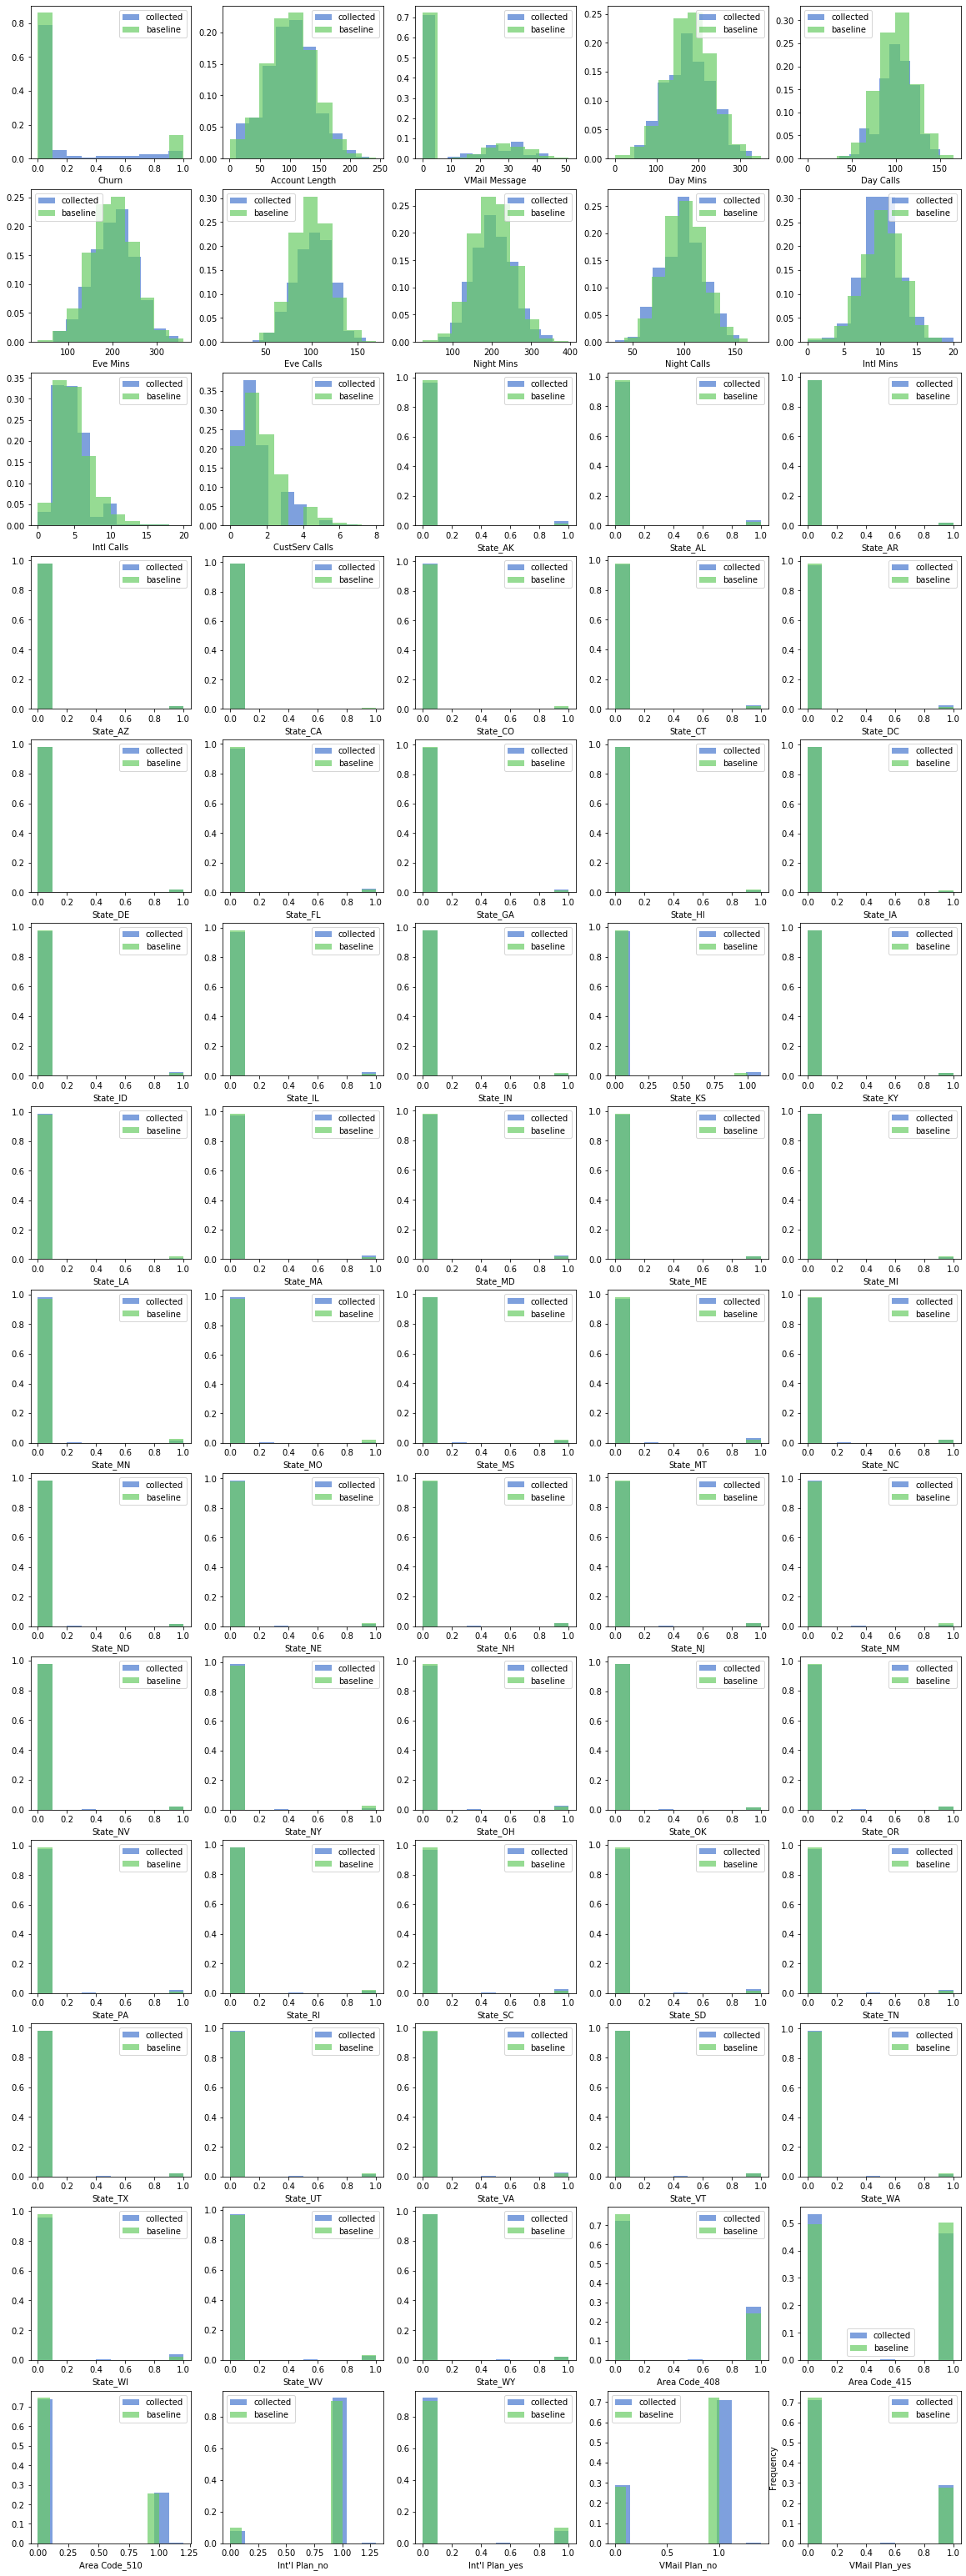

In [115]:
mu.show_distributions(features, feature_baselines)

## Clean up

If you no longer need this notebook, clean up your environment by running the following cell. It removes the hosted endpoint that you created for this walkthrough and prevents you from incurring charges for running an instance that you no longer need. It also cleans up all artifacts related to the experiments. 

You'll also want to delete artifacts stored in the S3 bucket used in this notebook.

In [ ]:
sagemaker_session.delete_monitoring_schedule(mon_schedule_name)
sagemaker_session.delete_endpoint(xgb_predictor.endpoint)